In [2]:
import pickle
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sacrebleu import corpus_bleu, corpus_chrf
from sacrebleu.tokenizers import tokenizer_13a, tokenizer_zh
import spacy
import re
from datasets import load_dataset

import warnings
warnings.filterwarnings("ignore")

In [6]:
eval_df = pd.read_csv('../data/evaluation/eval.csv')

# Functions

In [10]:
def make_eval_df(datasets, hf_path, eval_path, eval_file_un, eval_file_nbest, eval_file_al):
    eval_df = []

    for dataset in datasets:
        # Load hf dataset
        hf_path_dat = hf_path.format(DATASET=dataset)
        hf_dat = load_dataset(hf_path_dat)['test']
        
        # Load eval files
        eval_path_dat = eval_path.format(DATASET=dataset)
        with open(f'{eval_path_dat}/{eval_file_un}', 'rb') as f:
            sc_un = pickle.load(f)
        with open(f'{eval_path_dat}/{eval_file_nbest}', 'rb') as f:
            sc_nbest = pickle.load(f)
        with open(f'{eval_path_dat}/{eval_file_al}', 'rb') as f:
            sc_al = pickle.load(f)

        # Populate eval df    
        df = pd.DataFrame()   
        df['dataset'] = [dataset] * len(hf_dat)
        df['src_lang'] = [lp[:2] for lp in hf_dat['lp']]
        df['ref_lang'] = [lp[-2:] for lp in hf_dat['lp']]
        df['lp'] = hf_dat['lp']
        df['src'] = hf_dat['src']
        df['ref'] = hf_dat['ref']
        df['mt_un'] = [x['mt'] for x in sc_un]
        df['mt_nbest'] = [x['mt'] for x in sc_nbest]
        df['mt_al'] = [x['mt'] for x in sc_al]
        df['xcomet_un'] = [x['score'] * 100 for x in sc_un]
        df['xcomet_nbest'] = [x['score'] * 100 for x in sc_nbest]
        df['xcomet_al'] = [x['score'] * 100 for x in sc_al]
        eval_df.append(df)

    # Concatenate dfs
    eval_df = pd.concat(eval_df).reset_index(drop=True)

    return eval_df

In [11]:
def compute_bleu(eval_df):
    eval_df['bleu_un'] = [
        corpus_bleu([mt], [[ref]], tokenize='zh').score if ref_lang == 'zh' else corpus_bleu([mt], [[ref]]).score
        for mt, ref, ref_lang in zip(eval_df['mt_un'], eval_df['ref'], eval_df['ref_lang'])
    ]
    eval_df['bleu_nbest'] = [
        corpus_bleu([mt], [[ref]], tokenize='zh').score if ref_lang == 'zh' else corpus_bleu([mt], [[ref]]).score
        for mt, ref, ref_lang in zip(eval_df['mt_nbest'], eval_df['ref'], eval_df['ref_lang'])
    ]
    eval_df['bleu_al'] = [
        corpus_bleu([mt], [[ref]], tokenize='zh').score if ref_lang == 'zh' else corpus_bleu([mt], [[ref]]).score
        for mt, ref, ref_lang in zip(eval_df['mt_al'], eval_df['ref'], eval_df['ref_lang'])
    ]

In [12]:
def compute_chrf(eval_df):
    eval_df['chrf_un'] = [corpus_chrf([mt], [[ref]]).score for mt, ref in zip(eval_df['mt_un'], eval_df['ref'])]
    eval_df['chrf_nbest'] = [corpus_chrf([mt], [[ref]]).score for mt, ref in zip(eval_df['mt_nbest'], eval_df['ref'])]
    eval_df['chrf_al'] = [corpus_chrf([mt], [[ref]]).score for mt, ref in zip(eval_df['mt_al'], eval_df['ref'])]

In [13]:
def compute_deltas(eval_df, features, percent=False):
    if not percent:    
        for feature in features:
            eval_df[f'delta_{feature}_nbest'] = eval_df[f'{feature}_nbest'] - eval_df[f'{feature}_un']
            eval_df[f'delta_{feature}_al'] = eval_df[f'{feature}_al'] - eval_df[f'{feature}_un']
    else:
        for feature in features:
            eval_df[f'pdelta_{feature}_nbest'] = 100 * (eval_df[f'{feature}_nbest'] - eval_df[f'{feature}_un']) / eval_df[f'{feature}_un']
            eval_df[f'pdelta_{feature}_al'] = 100 * (eval_df[f'{feature}_al'] - eval_df[f'{feature}_un']) / eval_df[f'{feature}_un']

In [39]:
def do_eval(eval_df, features, lps, display_mode='df'):
    cols = [col for col in eval_df.columns 
            if any([f in col for f in features]) and any([s in col for s in ['nbest', 'al']])
    ]
    df = eval_df.loc[np.isin(eval_df.lp, lps), ['src_lang', 'ref_lang', 'lp'] + cols]
    df_lp = df.groupby('lp')[cols].mean()
    df_lp = df_lp.loc[lps]
    df_lp.loc['xx-en'] = df.loc[df.ref_lang == 'en', cols].mean()
    df_lp.loc['en-xx'] = df.loc[df.src_lang == 'en', cols].mean()
    df_lp.loc['overall'] = df[cols].mean()
    df_lp.columns = pd.MultiIndex.from_tuples([(f, s) for f in features for s in ['nbest', 'al']])
    
    if display_mode == 'df':
        return df_lp

    elif display_mode == 'plot':
        plt.figure(figsize=(3.5 * len(features), 2.5))
        for i, feature in enumerate(features):
            plt.subplot(1, len(features), i+1)
            sub_df = df_lp[feature]
            groups = sub_df.index
            values1 = sub_df['nbest']
            values2 = sub_df['al']
            indices = range(len(groups))
            bar_width = 0.35
            plt.bar(indices, values1, bar_width, label='N-Best')
            plt.bar([i + bar_width for i in indices], values2, bar_width, label='Aligned')
            plt.xticks([i + bar_width / 2 for i in indices], groups, rotation=90)
            xticks_locs, xticks_labels = plt.xticks()
            for i, label in enumerate(xticks_labels):
                if label.get_text() in ['xx-en', 'en-xx', 'overall']:
                    xticks_labels[i].set_fontweight('bold')
            plt.xticks(xticks_locs, xticks_labels)
            plt.ylabel(feature)

        plt.legend()
        plt.subplots_adjust(wspace=0.3)
        plt.show()

In [15]:
def quantify_changes(eval_df):
    eval_df['has_changed_nbest'] = eval_df['mt_un'] != eval_df['mt_nbest']
    eval_df['has_changed_al'] = eval_df['mt_un'] != eval_df['mt_al']
    eval_df['bleu_un_nbest'] = [
        corpus_bleu([mt1], [[mt2]], tokenize='zh').score if ref_lang == 'zh' else corpus_bleu([mt1], [[mt2]]).score
        for mt1, mt2, ref_lang in zip(eval_df['mt_nbest'], eval_df['mt_un'], eval_df['ref_lang'])
    ]    
    eval_df['bleu_un_al'] = [
        corpus_bleu([mt1], [[mt2]], tokenize='zh').score if ref_lang == 'zh' else corpus_bleu([mt1], [[mt2]]).score
        for mt1, mt2, ref_lang in zip(eval_df['mt_al'], eval_df['mt_un'], eval_df['ref_lang'])
    ]
    eval_df['chrf_un_nbest'] = [corpus_chrf([mt1], [[mt2]]).score for mt1, mt2 in zip(eval_df['mt_un'], eval_df['mt_nbest'])]
    eval_df['chrf_un_al'] = [corpus_chrf([mt1], [[mt2]]).score for mt1, mt2 in zip(eval_df['mt_un'], eval_df['mt_al'])]

In [16]:
def get_lengths(eval_df, mode):
    if mode == 'char':    
        eval_df['num_char_un'] = [len(mt) for mt in eval_df['mt_un']]
        eval_df['num_char_nbest'] = [len(mt) for mt in eval_df['mt_nbest']]
        eval_df['num_char_al'] = [len(mt) for mt in eval_df['mt_al']]

    elif mode == 'tok':
        eval_df['num_tok_un'] = [
            len(tokenizer_13a.Tokenizer13a()(mt).split()) 
            if mt_lang != 'zh' else len(tokenizer_zh.TokenizerZh()(mt).split()) 
            for mt, mt_lang in zip(eval_df['mt_un'], eval_df['ref_lang'])
        ]
        eval_df['num_tok_nbest'] = [
            len(tokenizer_13a.Tokenizer13a()(mt).split()) 
            if mt_lang != 'zh' else len(tokenizer_zh.TokenizerZh()(mt).split()) 
            for mt, mt_lang in zip(eval_df['mt_nbest'], eval_df['ref_lang'])
        ]
        eval_df['num_tok_al'] = [
            len(tokenizer_13a.Tokenizer13a()(mt).split()) 
            if mt_lang != 'zh' else len(tokenizer_zh.TokenizerZh()(mt).split()) 
            for mt, mt_lang in zip(eval_df['mt_al'], eval_df['ref_lang'])
        ]

In [17]:
def get_aligned_words(eval_df, datasets, alw_path, alw_file_un, alw_file_nbest, alw_file_al):
    alw_df = []

    for dataset in datasets:        
        # Load word alignment files
        
        alw_path_dat = alw_path.format(DATASET=dataset)
        with open(f'{alw_path_dat}/{alw_file_un}', 'rb') as f:
            alw_un = pickle.load(f)
        with open(f'{alw_path_dat}/{alw_file_nbest}', 'rb') as f:
            alw_nbest = pickle.load(f)
        with open(f'{alw_path_dat}/{alw_file_al}', 'rb') as f:
            alw_al = pickle.load(f)

        # Populate eval df    
        df = pd.DataFrame()   
        df['src'] = [x['src'] for x in alw_un]
        df['mt_un'] = [x['mt'] for x in alw_un]
        df['mt_nbest'] = [x['mt'] for x in alw_nbest]
        df['mt_al'] = [x['mt'] for x in alw_al]
        df['alw_un'] = [x['aligned_words'] for x in alw_un]
        df['alw_nbest'] = [x['aligned_words'] for x in alw_nbest]
        df['alw_al'] = [x['aligned_words'] for x in alw_al]
        alw_df.append(df)

    # Concatenate dfs
    alw_df = pd.concat(alw_df).reset_index(drop=True)

    # Keep only translations that changed for both nbest and al
    alw_df = alw_df[(alw_df.mt_un != alw_df.mt_nbest) & (alw_df.mt_un != alw_df.mt_al)].reset_index(drop=True)
    
    # Update eval_df
    eval_df[['alw_un', 'alw_nbest', 'alw_al']] = alw_df[['alw_un', 'alw_nbest', 'alw_al']]

In [18]:
def assess_word_alignment(eval_df):
    for idx in tqdm(eval_df.index):
        # Process inputs
        if eval_df.loc[idx, 'src_lang'] == 'zh':
            wtok_src = tokenizer_zh.TokenizerZh()
        else:
            wtok_src = tokenizer_13a.Tokenizer13a()
        if eval_df.loc[idx, 'ref_lang'] == 'zh':
            wtok_mt = tokenizer_zh.TokenizerZh()
        else:
            wtok_mt = tokenizer_13a.Tokenizer13a()
        
        # Get number of words
        num_words_src = len(wtok_src(eval_df.loc[idx, 'src']).strip().split())
        num_words_mt_un = len(wtok_mt(eval_df.loc[idx, 'mt_un']).strip().split())
        num_words_mt_nbest = len(wtok_mt(eval_df.loc[idx, 'mt_nbest']).strip().split())
        num_words_mt_al = len(wtok_mt(eval_df.loc[idx, 'mt_al']).strip().split())
            
        # Compute USW, UTW and TNM
        alw_un, alw_nbest, alw_al = eval_df.loc[idx, ['alw_un', 'alw_nbest', 'alw_al']]
        try:
            alsw_un, alsw_nbest, alsw_al = set(x[0] for x in alw_un), set(x[0] for x in alw_nbest), set(x[0] for x in alw_al)
            altw_un, altw_nbest, altw_al = set(x[1] for x in alw_un), set(x[1] for x in alw_nbest), set(x[1] for x in alw_al)
            eval_df.loc[idx, ['usw_un', 'usw_nbest', 'usw_al']] = (
                (1 - len(alsw_un) / num_words_src) * 100, 
                (1 - len(alsw_nbest) / num_words_src) * 100, 
                (1 - len(alsw_al) / num_words_src) * 100
            )
            eval_df.loc[idx, ['utw_un', 'utw_nbest', 'utw_al']] = (
                (1 - len(altw_un) / num_words_mt_un) * 100, 
                (1 - len(altw_nbest) / num_words_mt_nbest) * 100, 
                (1 - len(altw_al) / num_words_mt_al) * 100
            )
            eval_df.loc[idx, ['tnm_un', 'tnm_nbest', 'tnm_al']] = (
                sum([abs(i / num_words_src - j / num_words_mt_un) for i, j in alw_un]) / len(alw_un) * 100, 
                sum([abs(i / num_words_src - j / num_words_mt_nbest) for i, j in alw_nbest]) / len(alw_nbest) * 100, 
                sum([abs(i / num_words_src - j / num_words_mt_al) for i, j in alw_al]) / len(alw_nbest) * 100
            )
        except:
            pass

In [19]:
def extract_named_entities(eval_df):
    nlp = spacy.load("xx_ent_wiki_sm")
    eval_df['names_ref'] = [set(ent.text for ent in nlp(s).ents) for s in tqdm(eval_df['ref'], desc='References')]
    eval_df['names_un'] = [set(ent.text for ent in nlp(s).ents) for s in tqdm(eval_df['mt_un'], desc='Unaligned')]
    eval_df['names_nbest'] = [set(ent.text for ent in nlp(s).ents) for s in tqdm(eval_df['mt_nbest'], desc='N-Best')]
    eval_df['names_al'] = [set(ent.text for ent in nlp(s).ents) for s in tqdm(eval_df['mt_al'], desc='Aligned')]

In [20]:
def compute_f1(eval_df, features):
    for feature in features:
        # Compute precision
        eval_df[f'{feature}_P_un'] = [
            len(names_ref & names) / len(names) * 100 if len(names) > 0 else None 
            for names_ref, names in zip(eval_df[f'{feature}_ref'], eval_df[f'{feature}_un'])
        ]
        eval_df[f'{feature}_P_nbest'] = [
            len(names_ref & names) / len(names) * 100 if len(names) > 0 else None 
            for names_ref, names in zip(eval_df[f'{feature}_ref'], eval_df[f'{feature}_nbest'])
        ]
        eval_df[f'{feature}_P_al'] = [
            len(names_ref & names) / len(names) * 100 if len(names) > 0 else None 
            for names_ref, names in zip(eval_df[f'{feature}_ref'], eval_df[f'{feature}_al'])
        ]

        # Compute recall
        eval_df[f'{feature}_R_un'] = [
            len(names_ref & names) / len(names_ref) * 100 if len(names_ref) > 0 else None 
            for names_ref, names in zip(eval_df[f'{feature}_ref'], eval_df[f'{feature}_un'])
        ]
        eval_df[f'{feature}_R_nbest'] = [
            len(names_ref & names) / len(names_ref) * 100 if len(names_ref) > 0 else None 
            for names_ref, names in zip(eval_df[f'{feature}_ref'], eval_df[f'{feature}_nbest'])
        ]
        eval_df[f'{feature}_R_al'] = [
            len(names_ref & names) / len(names_ref) * 100 if len(names_ref) > 0 else None 
            for names_ref, names in zip(eval_df[f'{feature}_ref'], eval_df[f'{feature}_al'])
        ]

        # Compute F1
        eval_df[f'{feature}_F1_un'] = 2 / (1 / eval_df[f'{feature}_P_un'] + 1 / eval_df[f'{feature}_R_un'])
        eval_df[f'{feature}_F1_nbest'] = 2 / (1 / eval_df[f'{feature}_P_nbest'] + 1 / eval_df[f'{feature}_R_nbest'])
        eval_df[f'{feature}_F1_al'] = 2 / (1 / eval_df[f'{feature}_P_al'] + 1 / eval_df[f'{feature}_R_al'])

In [21]:
def extract_numbers(eval_df):
    eval_df['numbers_ref'] = [set(re.findall( r'\d+', s)) for s in eval_df['ref']]
    eval_df['numbers_un'] = [set(re.findall( r'\d+', s)) for s in eval_df['mt_un']]
    eval_df['numbers_nbest'] = [set(re.findall( r'\d+', s)) for s in eval_df['mt_nbest']]
    eval_df['numbers_al'] = [set(re.findall( r'\d+', s)) for s in eval_df['mt_al']]

In [22]:
def count_punct_symbols(eval_df, punct_symbols):
    eval_df['num_punct_un'] = [len([char for char in mt if char in punct_symbols]) for mt in eval_df['mt_un']]
    eval_df['num_punct_nbest'] = [len([char for char in mt if char in punct_symbols]) for mt in eval_df['mt_nbest']]
    eval_df['num_punct_al'] = [len([char for char in mt if char in punct_symbols]) for mt in eval_df['mt_al']]

In [23]:
def print_string(string, lang, max_words_per_line):
    # Tokenize text
    if lang == 'zh':
        string_tok = tokenizer_zh.TokenizerZh()(string).split()
    else:
        string_tok = tokenizer_13a.Tokenizer13a()(string).split()
    num_lines = int(np.ceil(len(string_tok) / max_words_per_line))
    
    # Print with max_words_per_line
    string_pr = []
    for i in range(num_lines):
        string_pr.append(' '.join(string_tok[i * max_words_per_line : (i+1) * max_words_per_line]))
    string_pr = '\n'.join(string_pr)
    print(string_pr)

# Set-up

In [42]:
# Make evaluation dataset with xcomet scores
datasets = ['wmt22-test', 'wmt23-test']
eval_path = '../data/evaluation/{DATASET}/ALMA-13B'
eval_file_un = 'unaligned/xcomet_xl_rf_greedy.pkl'
eval_file_nbest = 'unaligned/xcomet_xl_rf_nbest_N5_t0.25_p0.6.pkl'
eval_file_al = 'aligned/xcomet_xl_rf_greedy.pkl'
hf_path = 'hgissbkh/{DATASET}'
eval_df = make_eval_df(datasets, hf_path, eval_path, eval_file_un, eval_file_nbest, eval_file_al)

# Motivations

In [43]:
# Compute lexical metrics and deltas
compute_bleu(eval_df)
compute_chrf(eval_df)
compute_deltas(eval_df, ['xcomet', 'bleu', 'chrf'])

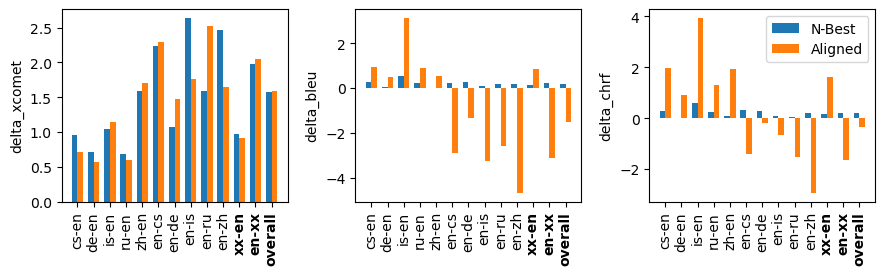

delta_xcomet           delta_bleu           delta_chrf          
               nbest        al      nbest        al      nbest        al
lp                                                                      
cs-en       0.952784  0.718683   0.284224  0.926758   0.274905  1.974145
de-en       0.715531  0.565958   0.036852  0.491645  -0.000397  0.908409
is-en       1.039685  1.136594   0.524836  3.134089   0.578758  3.943643
ru-en       0.681199  0.602211   0.240644  0.887114   0.233934  1.291410
zh-en       1.594174  1.704392  -0.000832  0.526255   0.096422  1.931775
en-cs       2.235020  2.294978   0.229756 -2.911803   0.313708 -1.417571
en-de       1.071531  1.471819   0.281847 -1.335804   0.293805 -0.174451
en-is       2.634525  1.757807   0.079815 -3.262250   0.078279 -0.672679
en-ru       1.590759  2.523817   0.193168 -2.601824   0.048098 -1.518455
en-zh       2.465944  1.645721   0.180671 -4.674775   0.191799 -2.936573
xx-en       0.966559  0.915094   0.154716  0.853250   0.170507  1.597816
en-xx       1.978562  2.042568   0.207045 -3.104318   0.195019 -1.653501
overall     1.569702  1.587056   0.185903 -1.505418   0.185116 -0.339934

In [44]:
# Display results
lps = [
    'cs-en', 
    'de-en', 
    'is-en', 
    'ru-en', 
    'zh-en', 
    'en-cs', 
    'en-de', 
    'en-is', 
    'en-ru', 
    'en-zh'
]
features = ['delta_xcomet', 'delta_bleu', 'delta_chrf']
do_eval(eval_df, features, lps, display_mode='plot')
do_eval(eval_df, features, lps, display_mode='df')

In [45]:
# Quantify translation changes (nbest vs. al)
quantify_changes(eval_df)

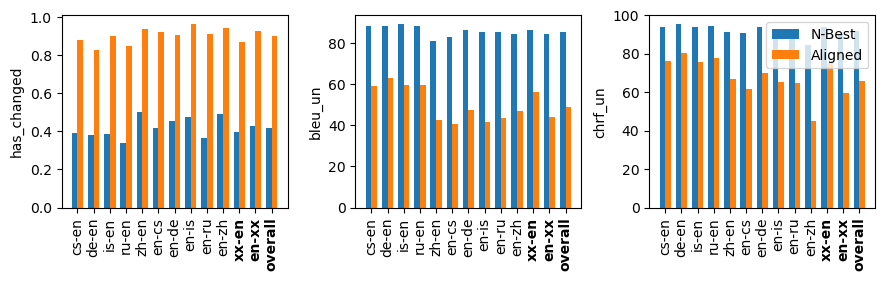

has_changed              bleu_un               chrf_un           
              nbest        al      nbest         al      nbest         al
lp                                                                       
cs-en      0.390193  0.877762  88.424908  59.276741  93.906100  76.357004
de-en      0.380336  0.827045  88.153496  63.198888  95.248972  80.098618
is-en      0.384000  0.902000  89.272339  59.515829  93.914890  75.579585
ru-en      0.340718  0.846759  88.233240  59.869655  94.412568  77.685615
zh-en      0.499610  0.938977  80.924336  42.738900  91.233476  66.579622
en-cs      0.416492  0.921261  83.031896  40.827902  90.743516  61.826609
en-de      0.453189  0.907331  86.305090  47.603852  93.643132  69.845964
en-is      0.476000  0.963000  85.699090  41.682263  92.007698  65.428563
en-ru      0.366855  0.912692  85.384666  43.585673  92.828007  64.589712
en-zh      0.489410  0.944705  84.569703  47.024002  84.365615  44.985879
xx-en      0.397284  0.871687  86.471318  56.290233  93.734505  75.214368
en-xx      0.430547  0.925218  84.663370  44.244843  90.032080  59.263446
overall    0.417109  0.903591  85.393800  49.111310  91.527899  65.707789

In [46]:
# Display results
do_eval(eval_df, ['has_changed', 'bleu_un', 'chrf_un'], lps, display_mode='plot')
do_eval(eval_df, ['has_changed', 'bleu_un', 'chrf_un'], lps, display_mode='df')

# Analysis

We only consider changed translations

In [48]:
# Filter out changeed translations only
eval_df = eval_df.loc[(eval_df.has_changed_nbest == True) & (eval_df.has_changed_al == True)].reset_index(drop=True)
# eval_df = pd.read_csv('../data/evaluation/eval.csv')

## Translation length

In [371]:
get_lengths(eval_df, 'char')
get_lengths(eval_df, 'tok')
compute_deltas(eval_df, ['num_char', 'num_tok'])

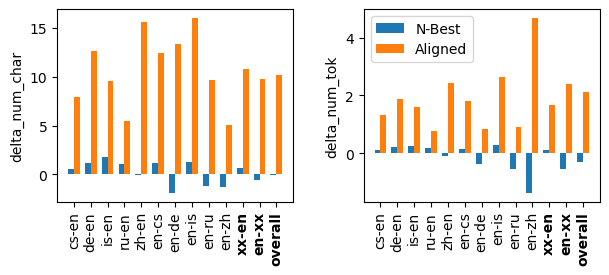

delta_num_char            delta_num_tok          
                 nbest         al         nbest        al
lp                                                       
cs-en         0.551020   7.890538      0.116883  1.315399
de-en         1.128358  12.663433      0.204478  1.894030
is-en         1.797872   9.587766      0.255319  1.603723
ru-en         1.049153   5.461017      0.169492  0.776836
zh-en        -0.104572  15.569627     -0.093537  2.440357
en-cs         1.171677  12.378560      0.155854  1.812104
en-de        -1.877595  13.370795     -0.370079  0.833214
en-is         1.281780  16.029661      0.269068  2.622881
en-ru        -1.207792   9.697716     -0.541424  0.910882
en-zh        -1.334226   5.089752     -1.373744  4.692565
xx-en         0.698887  10.816802      0.093623  1.664811
en-xx        -0.596610   9.816036     -0.551893  2.394863
overall      -0.102548  10.197697     -0.305713  2.116444

In [49]:
do_eval(eval_df, ['delta_num_char', 'delta_num_tok'], lps, display_mode='plot')
do_eval(eval_df, ['delta_num_char', 'delta_num_tok'], lps, display_mode='df')

## Word alignment

USW, UTW, TNM

In [373]:
dataset = 'wmt22-test'
alw_path = '../data/evaluation/{DATASET}/ALMA-13B'
alw_file_un = 'unaligned/aligned_words_greedy.pkl'
alw_file_nbest = 'unaligned/aligned_words_nbest_N5_t0.25_p0.6.pkl'
alw_file_al = 'aligned/aligned_words_greedy.pkl'
get_aligned_words(eval_df, datasets, alw_path, alw_file_un, alw_file_nbest, alw_file_al)

In [374]:
assess_word_alignment(eval_df)
compute_deltas(eval_df, ['usw', 'utw', 'tnm'])

100%|██████████| 15544/15544 [00:16<00:00, 926.57it/s]


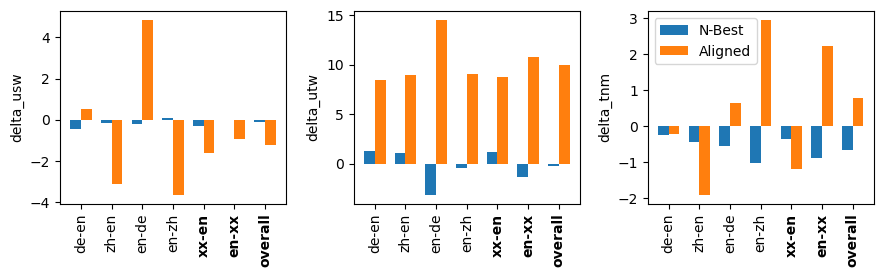

delta_usw           delta_utw            delta_tnm          
            nbest        al     nbest         al     nbest        al
lp                                                                  
de-en   -0.469666  0.507285  1.302564   8.491789 -0.247414 -0.217807
zh-en   -0.146892 -3.112043  1.091767   8.984354 -0.447920 -1.908527
en-de   -0.216665  4.853309 -3.143389  14.554564 -0.553993  0.628646
en-zh    0.076772 -3.636619 -0.469470   9.052784 -1.035258  2.953471
xx-en   -0.281885 -1.598341  1.179928   8.778350 -0.364062 -1.201422
en-xx   -0.016756 -0.930612 -1.321732  10.806375 -0.881864  2.212476
overall -0.128720 -1.212595 -0.265278   9.949937 -0.663196  0.770782

In [50]:
# lps = ['de-en', 'zh-en', 'en-de', 'en-zh'] (cf. languages supported by the aligner)
do_eval(eval_df, ['delta_usw', 'delta_utw', 'delta_tnm'], ['de-en', 'zh-en', 'en-de', 'en-zh'], display_mode='plot')
do_eval(eval_df, ['delta_usw', 'delta_utw', 'delta_tnm'], ['de-en', 'zh-en', 'en-de', 'en-zh'], display_mode='df')

## Name and number recognition

In [376]:
extract_named_entities(eval_df)
extract_numbers(eval_df)
compute_f1(eval_df, ['names', 'numbers'])
compute_deltas(eval_df, ['names_F1', 'numbers_F1'])

Aligned: 100%|██████████| 15544/15544 [00:39<00:00, 394.06it/s]


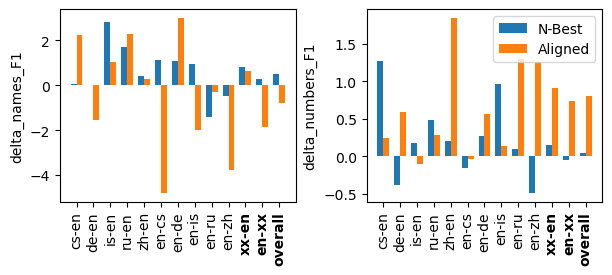

delta_names_F1           delta_numbers_F1          
                 nbest        al            nbest        al
lp                                                         
cs-en         0.035758  2.239949         1.264881  0.242131
de-en         0.019849 -1.536812        -0.376482  0.587192
is-en         2.815914  1.046685         0.180832 -0.105133
ru-en         1.689830  2.279497         0.491826  0.289554
zh-en         0.415877  0.293009         0.201026  1.846582
en-cs         1.123274 -4.802187        -0.150291 -0.032826
en-de         1.094369  3.013727         0.277822  0.558652
en-is         0.956977 -1.995248         0.965023  0.142857
en-ru        -1.401285 -0.300134         0.093908  1.295661
en-zh        -0.466171 -3.764612        -0.483957  1.253066
xx-en         0.832624  0.636833         0.148210  0.905743
en-xx         0.273045 -1.851429        -0.043186  0.735056
overall       0.508661 -0.779883         0.040869  0.810265

In [51]:
do_eval(eval_df, ['delta_names_F1', 'delta_numbers_F1'], lps, display_mode='plot')
do_eval(eval_df, ['delta_names_F1', 'delta_numbers_F1'], lps, display_mode='df')

## Punctuation insertion

In [378]:
punct_symbols = ['.', ',', '!', '?', ':', ';']
count_punct_symbols(eval_df, punct_symbols)
compute_deltas(eval_df, ['num_punct'])

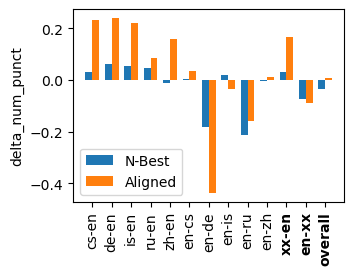

delta_num_punct          
                  nbest        al
lp                               
cs-en          0.031540  0.233766
de-en          0.061940  0.241045
is-en          0.053191  0.220745
ru-en          0.044633  0.087006
zh-en         -0.013137  0.159222
en-cs          0.002769  0.033623
en-de         -0.181818 -0.437366
en-is          0.019068 -0.036017
en-ru         -0.213614 -0.159427
en-zh         -0.002344  0.009712
xx-en          0.029352  0.166835
en-xx         -0.075083 -0.090474
overall       -0.035255  0.007656

In [52]:
do_eval(eval_df, ['delta_num_punct'], lps, display_mode='plot')
do_eval(eval_df, ['delta_num_punct'], lps, display_mode='df')